## Loading and plotting the data

In [37]:
import numpy as np
import pandas as pd

df = pd.read_csv("C:\\Users\\Win 1809 UEFI\\Desktop\\99.csv", header=0, delimiter=",", quoting=0)

In [39]:
df.head(4)
#Converting the sentiment to numerical data to plot the histogram
for i in range(len(df)):
    if df.Recommended[i]=='1':
        df.loc[i,'Recommended'] = int(1)
    elif df.Recommended[i]=='0':
        df.loc[i,'Recommended'] = int(-1)
  #  elif df.airline_sentiment[i]=='Neutral':
   #     df.loc[i,'Sentiment'] = int(0)

## Removing mentons and URLs and converting # to _hashtag

In [41]:
import re
regexp_mention = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)'
pattern_mention = re.compile(regexp_mention, re.UNICODE | re.IGNORECASE)

for i in range(len(df)):
    df.loc[i,'review']  = pattern_mention.sub("", df.review[i])
#print(df.TextnoMen)

In [42]:
regexp_url = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
pattern_url = re.compile(regexp_url, re.UNICODE | re.IGNORECASE)

for i in range(len(df)):
    df.loc[i,'review']  = pattern_url.sub("", df.review[i])

In [43]:
regexp_hashtag = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)'
pattern_hashtag = re.compile(regexp_hashtag, re.UNICODE | re.IGNORECASE)

for i in range(len(df)):
    df.loc[i,'review'] = pattern_hashtag.sub(r'hashtag_\1', df.review[i])

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

#Creating different datasets based on Airline
df = df.sample(frac=1, random_state= 100)

#print(df.airline.unique())
#dfUnited = df[df.airline=='United']
#dfAmerican = df[df.airline=='American']
#dfSouthwest = df[df.airline=='Southwest']
#dfDelta = df[df.airline=='Delta']
#dfUSAir = df[df.airline=='US Airways']
#dfVirgin = df[df.airline=='Virgin America']


## Function for Logistic Regression model with 10-fold cross validation

In [45]:
from sklearn.model_selection import KFold
def CreateModelLR(df):
    
    df_text = df['review']
    df_sentiment = df['Recommended']
    
    Accuracylist = []
    f1scorelist = []
    CVaccuracy = []
    CVf1Score = []
    
    kf = KFold(n_splits=10, shuffle = True, random_state = 2)
    
    
    for i in range(1,10) : 
        for train, valid in kf.split(df_sentiment):

            X_train_text = df_text.iloc[train]
            yTrain = df_sentiment.iloc[train]

            X_valid_text = df_text.iloc[valid]
            yValid = df_sentiment.iloc[valid]

            #print("Total number of records = %d" %len(df))
            #print("Train and Test : %s and %s" %(yTrain.shape, yValid.shape))

            vect = CountVectorizer(binary = False, min_df = 5, stop_words = 'english')

            XTrain = vect.fit_transform(X_train_text)
            #print(XTrain.shape)

            XValid = vect.transform(X_valid_text)
            #print(XValid.shape)

            LogR = LogisticRegression(C = 5)
            LogR.fit(XTrain, yTrain)

            Predited = LogR.predict(XValid)

            Accuracylist.append(accuracy_score(yValid, Predited))
            f1scorelist.append(f1_score(yValid, Predited, average = "weighted"))

            performance=[]
            f1Score = np.array(f1scorelist).mean(0)
            Accuracy = np.array(Accuracylist).mean(0)
        
        CVaccuracy.append(Accuracy)
        CVf1Score.append(f1Score)
    #performace = [Acuracy,f1Score]
    #print(CVaccuracy)
    #print(CVf1Score)
    minAccidx = np.array(CVaccuracy).argmax()
   
    airline = set(df.airline)
    print("LOGISTIC REGRESSION")
    print("Airlines = %s ; Best Cross validation Accuracy of the model is %f ; F1-Score is %f" % (airline,CVaccuracy[minAccidx],CVf1Score[minAccidx]))
    print("----------------------------------------------------------------------------------------------")
    print("")

## Function for Naive Bayes model with 10-fold cross validation

In [46]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
def CreateModelNB(df):
    
    df_text = df['review']
    df_sentiment = df['Recommended']
    
    Accuracylist = []
    f1scorelist = []
    CVaccuracy = []
    CVf1Score = []
    
    kf = KFold(n_splits=10, shuffle = True, random_state = 2)
    alpha = [1e-8, 5e-8,1e-7, 5e-7,1e-6, 5e-6,1e-5, 5e-5,1e-4, 5e-4,1e-3, 5e-3,1e-2, 5e-2,1e-1, 5e-1 ]
    
    for i in alpha : 
        for train, valid in kf.split(df_sentiment):

            X_train_text = df_text.iloc[train]
            yTrain = df_sentiment.iloc[train]

            X_valid_text = df_text.iloc[valid]
            yValid = df_sentiment.iloc[valid]

            #print("Total number of records = %d" %len(df))
            #print("Train and Test : %s and %s" %(yTrain.shape, yValid.shape))

            vect = CountVectorizer(binary = False, min_df = 5, stop_words = 'english')

            XTrain = vect.fit_transform(X_train_text)
            #print(XTrain.shape)

            XValid = vect.transform(X_valid_text)
            #print(XValid.shape)

            MNB = MultinomialNB(i)
            MNB.fit(XTrain, yTrain)

            Predited = MNB.predict(XValid)

            Accuracylist.append(accuracy_score(yValid, Predited))
            f1scorelist.append(f1_score(yValid, Predited, average = "weighted"))

            performance=[]
            f1Score = np.array(f1scorelist).mean(0)
            Accuracy = np.array(Accuracylist).mean(0)
        
        CVaccuracy.append(Accuracy)
        CVf1Score.append(f1Score)
    #performace = [Acuracy,f1Score]
    #print(CVaccuracy)
    #print(CVf1Score)
    minAccidx = np.array(CVaccuracy).argmax()
    
    airline = set(df.airline)
    print("NAIVE BAYES")
    print("Airlines = %s ; Best Cross validation Accuracy of the model is %f ; F1-Score is %f" % (airline,CVaccuracy[minAccidx],CVf1Score[minAccidx]))
    print("----------------------------------------------------------------------------------------------")
    print("")

## All Airlines

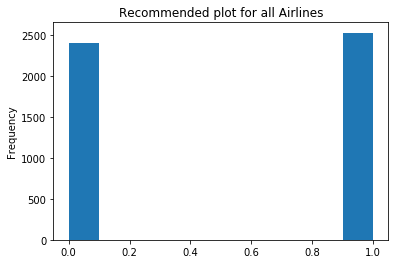

LOGISTIC REGRESSION
Airlines = {'flydubai', 'kuwait airways', 'Saudi Arabian', 'turkish airlines', 'Qatarairways', 'Royal Jordanian Airlines', 'oman air', 'emirates', 'etihad airways', 'gulf air'} ; Best Cross validation Accuracy of the model is 0.851212 ; F1-Score is 0.851201
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'flydubai', 'kuwait airways', 'Saudi Arabian', 'turkish airlines', 'Qatarairways', 'Royal Jordanian Airlines', 'oman air', 'emirates', 'etihad airways', 'gulf air'} ; Best Cross validation Accuracy of the model is 0.850376 ; F1-Score is 0.850103
----------------------------------------------------------------------------------------------



In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

df['Recommended'].plot.hist()
plt.title("Recommended plot for all Airlines")
plt.show()
CreateModelLR(df)
CreateModelNB(df)

## Changing the percentage of training data while reserving 20% for test
There are two stark observations that can be made from the graph above:
1. We can see that the perfomance of both the models improves with the increase in the percentage of the training data. For each of the models, 80% training and 20% test gives the best performance
2. It can be notices that overall, logistic regression performs better on this data and gives a higher accuracy at all percentages of training data. 

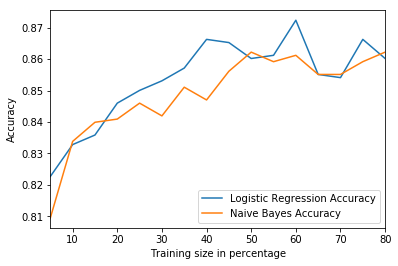

In [48]:
#Deviding into test and train - Train:test :: 80%:20%

def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

AccuracylistLog = []
AccuracylistNB = []

for i in frange(0.05,0.85,0.05):
    X_train_text = df['review'][:int(len(df)*i)]
    yTrain = df['Recommended'][:int(len(df)*i)]

    X_valid_text = df['review'][int(len(df)*0.8):]
    yValid = df['Recommended'][int(len(df)*0.8):]

    total = len(X_train_text) + len(X_valid_text)
    #print("Total number of records = %d" %total)
    #print("Train and Test : %s and %s" %(yTrain.shape, yValid.shape))

    vect = CountVectorizer(binary = False, min_df = 5, stop_words = 'english')

    XTrain = vect.fit_transform(X_train_text)
    #print(XTrain.shape)

    XValid = vect.transform(X_valid_text)
    #print(XValid.shape)

    LogR = LogisticRegression(C = 5)
    LogR.fit(XTrain, yTrain)
    
    MNB = MultinomialNB(1e-5)
    MNB.fit(XTrain, yTrain)

    PreditedLog = LogR.predict(XValid)
    PreditedNB = MNB.predict(XValid)

    AccLog = accuracy_score(yValid, PreditedLog)
    AccNB = accuracy_score(yValid, PreditedNB)

    AccuracylistLog.append(AccLog)
    AccuracylistNB.append(AccNB)
    

AccuracyLog = np.array(AccuracylistLog)
AccuracyNB = np.array(AccuracylistNB)

xaxis = np.arange(5,85,5)
plt.plot(xaxis,AccuracyLog , label = 'Logistic Regression Accuracy')
plt.plot(xaxis,AccuracyNB , label = 'Naive Bayes Accuracy')

plt.xlabel('Training size in percentage')
plt.ylabel('Accuracy')
plt.xlim(xaxis.min(), xaxis.max())
plt.legend(loc = 'lower right')
plt.show()